In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
import sys
import cv2
import numpy as np



In [2]:
# model.ipynb is inside: OIL_SPILL/notebooks/
# dataset.py is inside: OIL_SPILL/

BASE_DIR = Path.cwd().parent   # goes to OIL_SPILL/
print("BASE_DIR:", BASE_DIR)

# Tell Python where dataset.py lives
sys.path.insert(0, str(BASE_DIR))


BASE_DIR: c:\Users\pooji\OneDrive\Desktop\oil_spill


In [3]:
from dataset import OilSpillDataset


In [4]:
#augmentation

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),

    A.RandomCrop(height=256, width=256, p=0.5),
    A.GaussNoise(p=0.2),

    ToTensorV2()
])


In [6]:
DATA_DIR = BASE_DIR / "15298010"

IMG_TRAIN = DATA_DIR / "images" / "images" / "train"
IMG_VAL   = DATA_DIR / "images" / "images" / "val"

MASK_TRAIN = DATA_DIR / "masks" / "masks" / "train"
MASK_VAL   = DATA_DIR / "masks" / "masks" / "val"

print("IMG_TRAIN exists:", IMG_TRAIN.exists())
print("MASK_TRAIN exists:", MASK_TRAIN.exists())


IMG_TRAIN exists: True
MASK_TRAIN exists: True


In [7]:
print("Train images:", len(list(IMG_TRAIN.glob("*.png"))))
print("Val images  :", len(list(IMG_VAL.glob("*.png"))))
print("Train masks :", len(list(MASK_TRAIN.glob("*.png"))))
print("Val masks   :", len(list(MASK_VAL.glob("*.png"))))


Train images: 6455
Val images  : 1615
Train masks : 6455
Val masks   : 1615


In [8]:
train_dataset = OilSpillDataset(
    IMG_TRAIN,
    MASK_TRAIN,
    transform=train_transform
)

val_dataset = OilSpillDataset(
    IMG_VAL,
    MASK_VAL,
    transform=None
)


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)


In [10]:
train_ds = OilSpillDataset(IMG_TRAIN, MASK_TRAIN)
val_ds   = OilSpillDataset(IMG_VAL, MASK_VAL)

print(len(train_ds), len(val_ds))


6455 1615


In [11]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))


Train batches: 807
Val batches  : 202


In [12]:
images, masks = next(iter(train_loader))
print(images.shape)  # [8, 1, 256, 256]
print(masks.shape)   # [8, 1, 256, 256]


torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


In [13]:
#training

In [14]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [15]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool


In [16]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


In [17]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = Encoder(1, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.dec4 = Decoder(1024, 512)
        self.dec3 = Decoder(512, 256)
        self.dec2 = Decoder(256, 128)
        self.dec1 = Decoder(128, 64)

        # Final output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b = self.bottleneck(p4)

        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        return torch.sigmoid(self.final(d1))


In [18]:
model = UNet()
x = torch.randn(1, 1, 256, 256)
y = model(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)


Input shape : torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [19]:
#U-Net Architecture

In [20]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice


In [21]:
def combined_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [23]:
def train_one_epoch(model, loader):
    model.train()
    epoch_loss = 0

    for i, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [24]:
def validate(model, loader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(loader)


In [25]:
checkpoint = torch.load("checkpoint_unet.pth", map_location=device)

model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

start_epoch = checkpoint["epoch"] + 1
print(f"✅ Resuming training from epoch {start_epoch}")


✅ Resuming training from epoch 15


In [26]:
EPOCHS = 15  # total epochs you want

for epoch in range(start_epoch, EPOCHS):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss  : {val_loss:.4f}")


In [27]:
torch.save(model.state_dict(), "unet_oilspill.pth")
print("Model saved!")


Model saved!


In [28]:
model.load_state_dict(torch.load("unet_oilspill_aug.pth"))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'unet_oilspill_aug.pth'

In [34]:
import os
import torch

CHECKPOINT_PATH = "checkpoint_unet_aug.pth"

start_epoch = 0

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"✅ Resuming training from epoch {start_epoch}")
else:
    print("🆕 No checkpoint found. Starting from epoch 0")


🆕 No checkpoint found. Starting from epoch 0


In [31]:
EPOCHS = 10   # total epochs you want

for epoch in range(start_epoch, EPOCHS):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)

    print(f"[AUG] Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss  : {val_loss:.4f}")

    # 🔐 SAVE CHECKPOINT EVERY EPOCH
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }, CHECKPOINT_PATH)


KeyboardInterrupt: 

In [32]:
model.load_state_dict(torch.load("unet_oilspill_aug.pth"))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'unet_oilspill_aug.pth'

In [33]:
torch.save(model.state_dict(), "unet_oilspill_aug_final.pth")
print("🎉 Final augmented model saved")


🎉 Final augmented model saved


In [62]:
# Visual evaluation

In [37]:
# Load trained model
model.load_state_dict(torch.load("unet_oilspill.pth", map_location=device))
model.eval()

print("✅ Model loaded successfully")
 

✅ Model loaded successfully


In [38]:
images, masks = next(iter(val_loader))

images = images.to(device)
masks = masks.to(device)

print(images.shape, masks.shape)


torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


In [39]:
with torch.no_grad():
    outputs = model(images)

print(outputs.shape)


torch.Size([8, 1, 256, 256])


In [40]:
import matplotlib.pyplot as plt

def visualize_sample(img, gt_mask, pred_mask, idx=0):
    img = img[idx][0].cpu().numpy()
    gt = gt_mask[idx][0].cpu().numpy()
    pred = pred_mask[idx][0].cpu().numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.show()


In [41]:
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).float()


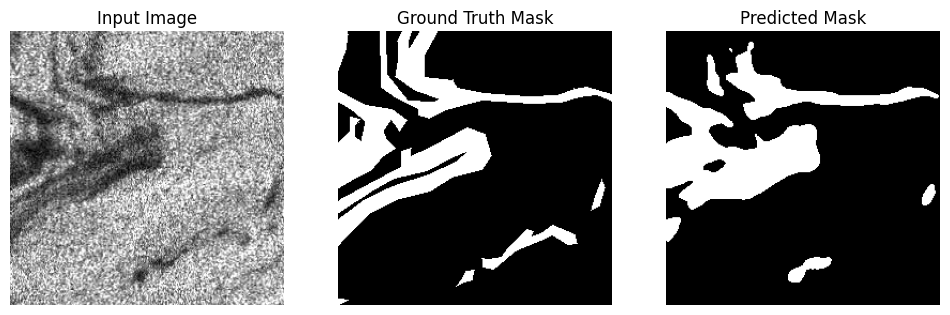

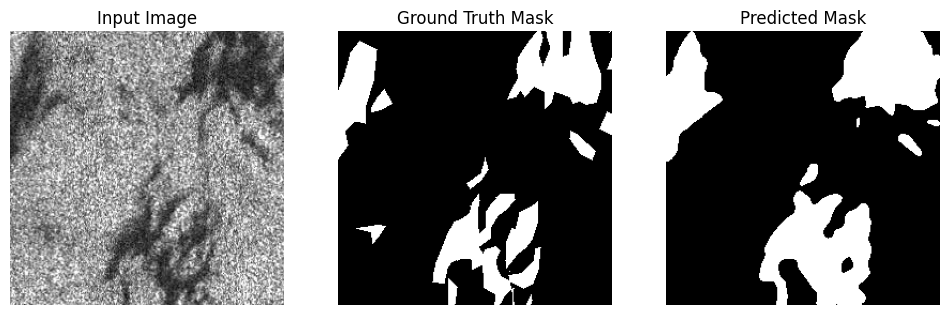

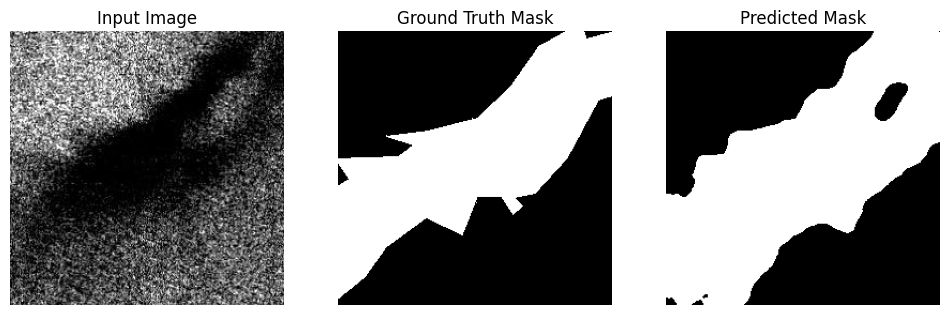

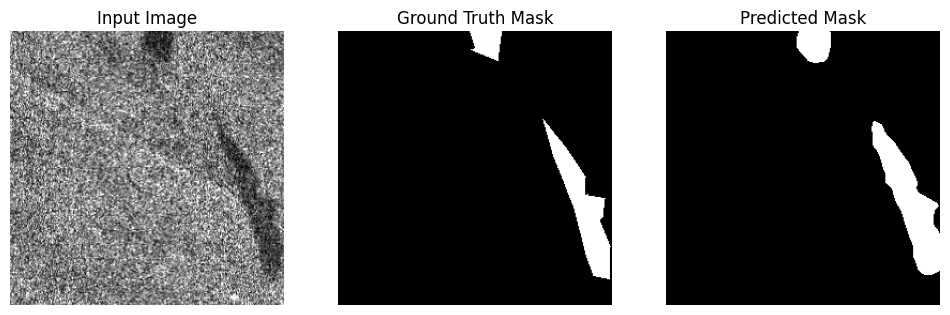

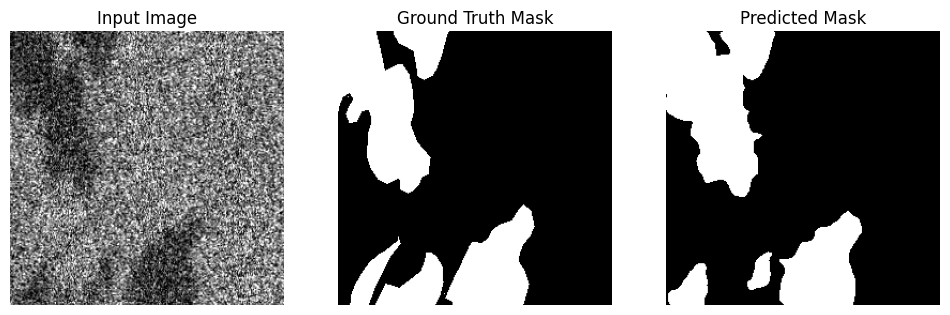

In [42]:
for i in range(5):
    visualize_sample(images, masks, preds, idx=i)


In [43]:
#Quantitative Evaluation

In [44]:
def threshold_preds(preds, threshold=0.5):
    return (preds > threshold).float()


In [45]:
def pixel_confusion_matrix(preds, targets):
    preds = preds.view(-1)
    targets = targets.view(-1)

    TP = ((preds == 1) & (targets == 1)).sum().item()
    TN = ((preds == 0) & (targets == 0)).sum().item()
    FP = ((preds == 1) & (targets == 0)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()

    return TP, FP, FN, TN


In [46]:
def segmentation_metrics(TP, FP, FN, TN):
    eps = 1e-7

    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    dice      = (2 * TP) / (2 * TP + FP + FN + eps)
    iou       = TP / (TP + FP + FN + eps)
    accuracy  = (TP + TN) / (TP + TN + FP + FN + eps)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Dice": dice,
        "IoU": iou
    }


In [47]:
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = torch.sigmoid(model(images))

binary_preds = threshold_preds(preds, threshold=0.5)

TP, FP, FN, TN = pixel_confusion_matrix(binary_preds, masks)

metrics = segmentation_metrics(TP, FP, FN, TN)

print("Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

print("\nMetrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Confusion Matrix:
TP: 83271, FP: 441017, FN: 0, TN: 0

Metrics:
Accuracy: 0.1588
Precision: 0.1588
Recall: 1.0000
Dice: 0.2741
IoU: 0.1588


In [48]:
for t in [0.3, 0.5, 0.7]:
    binary_preds = threshold_preds(preds, threshold=t)
    TP, FP, FN, TN = pixel_confusion_matrix(binary_preds, masks)
    metrics = segmentation_metrics(TP, FP, FN, TN)

    print(f"\nThreshold = {t}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"Dice:      {metrics['Dice']:.4f}")



Threshold = 0.3
Precision: 0.1588
Recall:    1.0000
Dice:      0.2741

Threshold = 0.5
Precision: 0.1588
Recall:    1.0000
Dice:      0.2741

Threshold = 0.7
Precision: 0.7875
Recall:    0.8718
Dice:      0.8275


In [49]:
#Error analysis + improvement

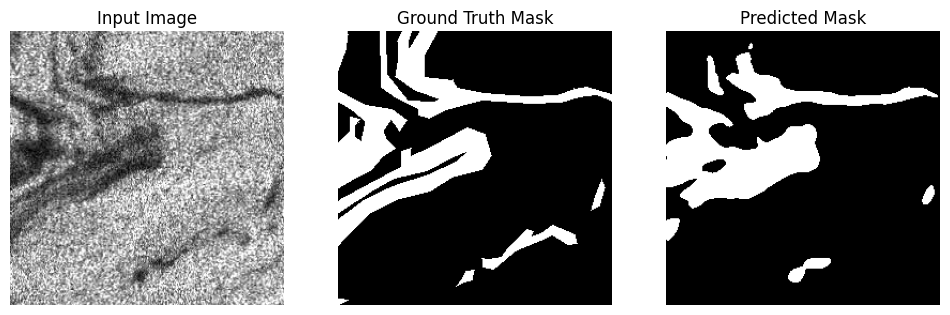

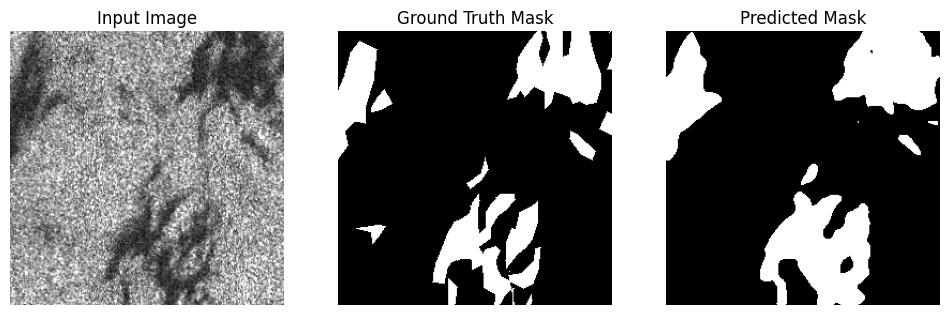

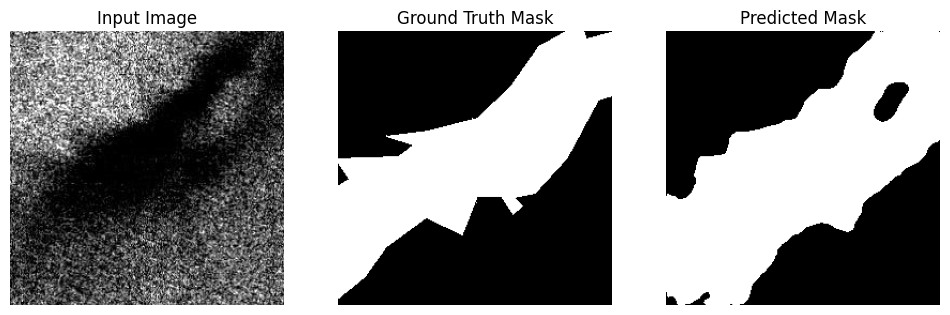

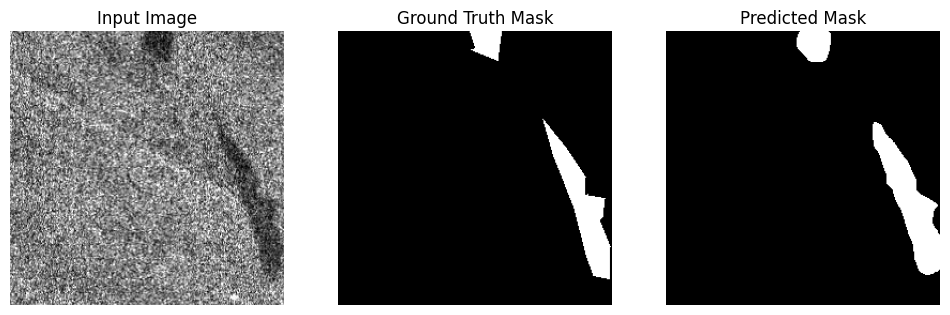

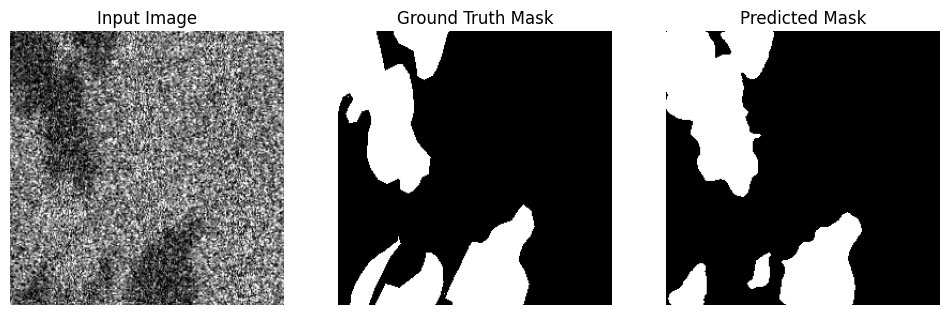

In [50]:
# Step 8A: Visual error analysis (5 samples)

model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    preds = model(images)
    preds_bin = (preds > 0.7).float()   # use best threshold

for i in range(5):
    visualize_sample(images, masks, preds_bin, idx=i)


In [51]:
def visualize_errors(img, gt, pred, idx=0):
    img = img[idx][0].cpu().numpy()
    gt = gt[idx][0].cpu().numpy()
    pred = pred[idx][0].cpu().numpy()

    fn = (gt == 1) & (pred == 0)   # missed oil
    fp = (gt == 0) & (pred == 1)   # false oil

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("False Negatives (Missed Oil)")
    plt.imshow(fn, cmap="hot")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("False Positives")
    plt.imshow(fp, cmap="hot")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("GT vs Prediction")
    plt.imshow(gt, cmap="gray", alpha=0.6)
    plt.imshow(pred, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()


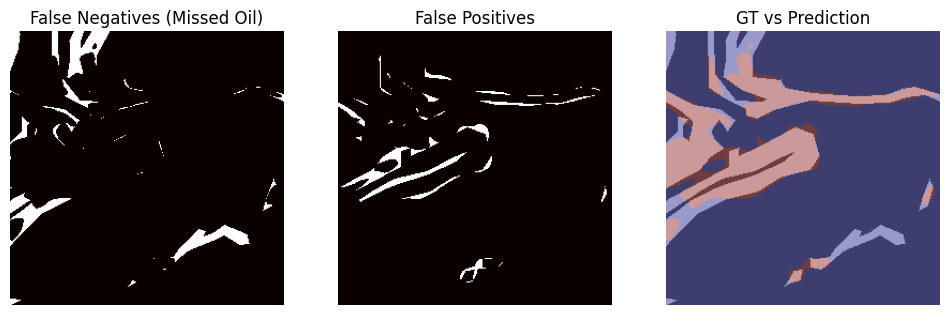

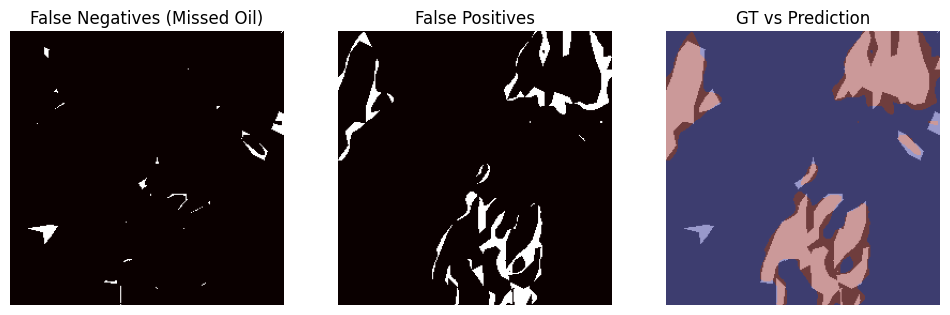

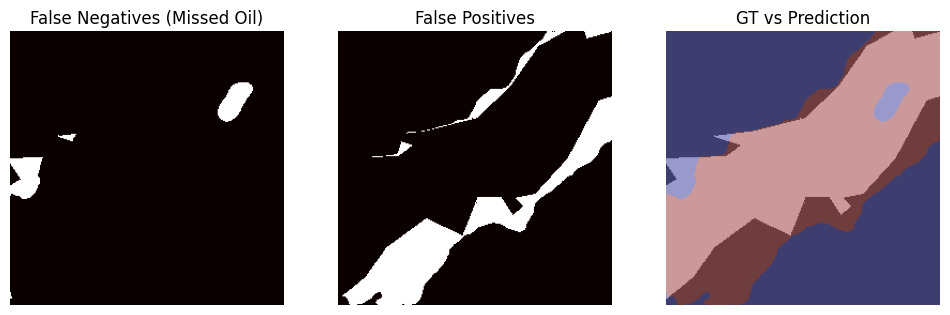

In [52]:
for i in range(3):
    visualize_errors(images, masks, preds_bin, idx=i)


In [53]:
model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    preds = model(images)          # raw probabilities (0–1)
    preds_06 = (preds > 0.6).float()


In [54]:
TP, FP, FN, TN = pixel_confusion_matrix(preds_06, masks)

print("Confusion Matrix @ threshold=0.6")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")


Confusion Matrix @ threshold=0.6
TP: 74567, FP: 22922, FN: 8704, TN: 418095


In [55]:
metrics_06 = segmentation_metrics(TP, FP, FN, TN)

print("\nMetrics @ threshold = 0.6")
for k, v in metrics_06.items():
    print(f"{k}: {v:.4f}")



Metrics @ threshold = 0.6
Accuracy: 0.9397
Precision: 0.7649
Recall: 0.8955
Dice: 0.8250
IoU: 0.7022


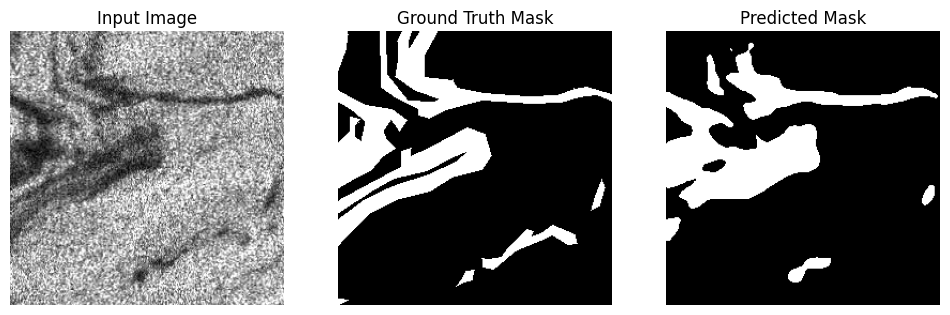

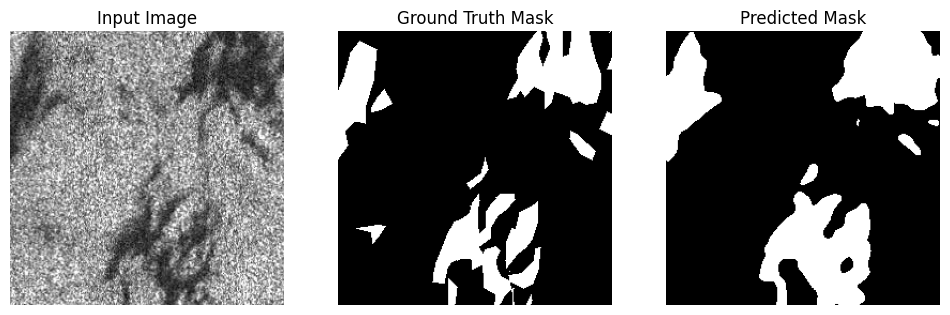

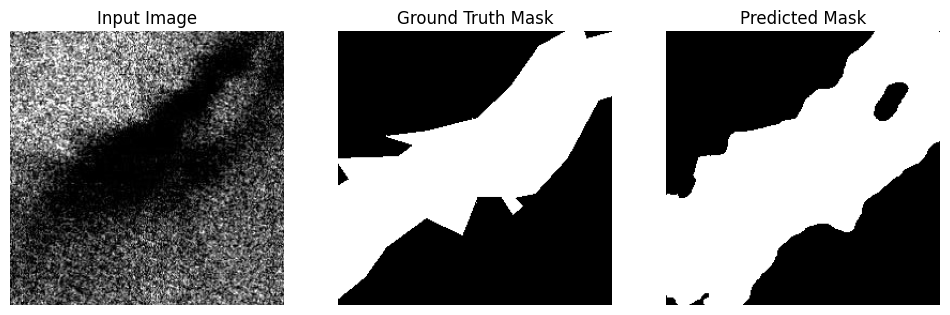

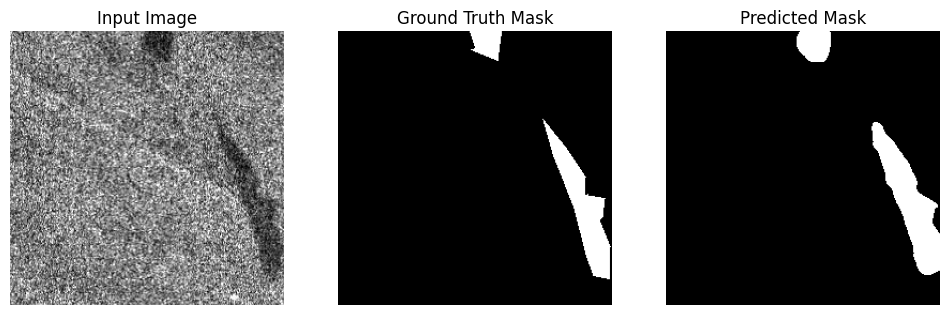

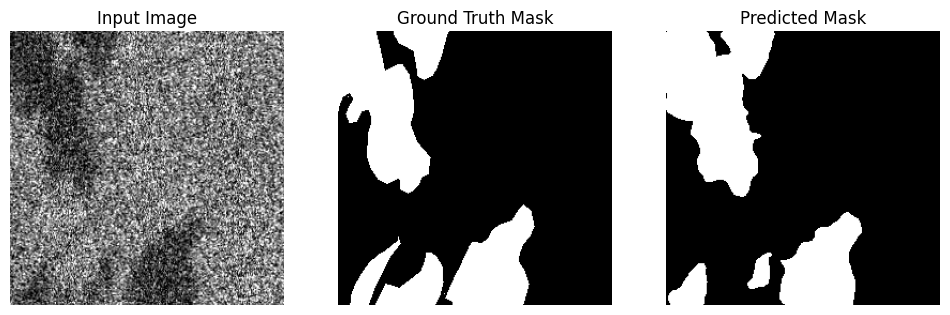

In [56]:
for i in range(5):
    visualize_sample(images, masks, preds_06, idx=i)


In [57]:
#Post-Processing (Morphological Operations)

In [58]:
def post_process_mask(mask, kernel_size=5):
    """
    mask: torch tensor (1, H, W) or (H, W)
    returns cleaned numpy mask (H, W)
    """
    if torch.is_tensor(mask):
        mask = mask.squeeze().cpu().numpy()

    mask = mask.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Remove small false positives
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Fill holes inside oil regions
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    return closed


In [59]:
model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    preds = model(images)
    preds_bin = (preds > 0.6).float()   # best threshold


In [60]:
#post processing

In [61]:
def visualize_post_processing(imgs, gt, pred_raw, pred_clean, idx=0):
    img = imgs[idx][0].cpu().numpy()
    gt = gt[idx][0].cpu().numpy()
    raw = pred_raw[idx][0].cpu().numpy()
    clean = pred_clean[idx]

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.title("Input Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("Ground Truth")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Raw Prediction")
    plt.imshow(raw, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Post-Processed")
    plt.imshow(clean, cmap="gray")
    plt.axis("off")

    plt.show()


In [62]:
processed_preds = []

for i in range(preds_bin.shape[0]):
    clean_mask = post_process_mask(preds_bin[i])
    processed_preds.append(clean_mask)

processed_preds = np.stack(processed_preds)


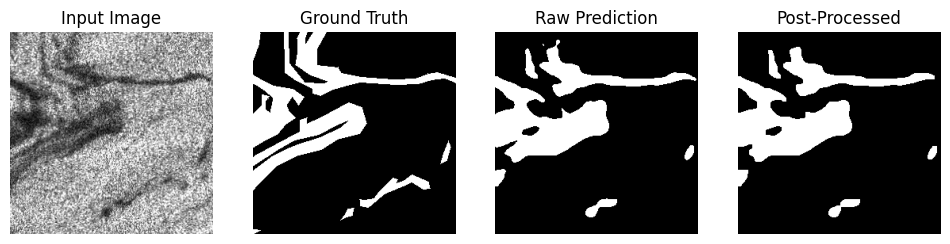

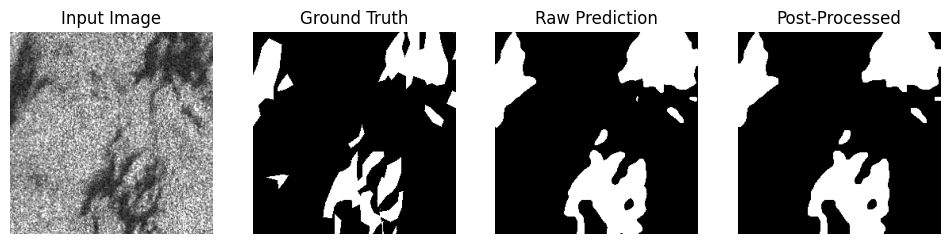

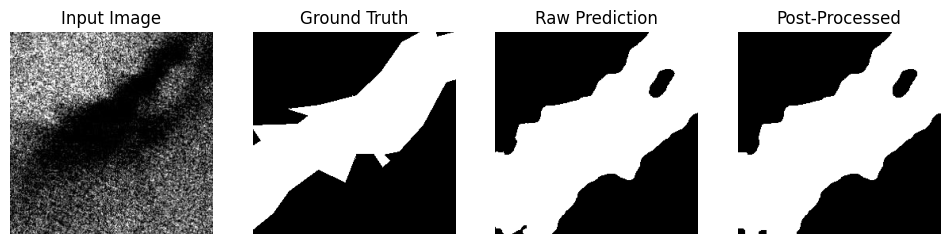

In [65]:
for i in range(3):
    visualize_post_processing(images, masks, preds_bin, processed_preds, idx=i)


In [72]:
def compute_oil_severity(binary_mask):
    """
    binary_mask: torch.Tensor or numpy array of shape (H, W)
    values must be 0 or 1
    """

    # Convert to numpy if tensor
    if hasattr(binary_mask, "cpu"):
        binary_mask = binary_mask.cpu().numpy()

    total_pixels = binary_mask.size
    oil_pixels = binary_mask.sum()

    oil_percentage = (oil_pixels / total_pixels) * 100

    # Severity classification
    if oil_percentage < 5:
        severity = "Low"
        risk = "Minimal environmental impact"
        color = "🟢"
    elif oil_percentage < 20:
        severity = "Medium"
        risk = "Moderate environmental risk"
        color = "🟡"
    else:
        severity = "High"
        risk = "Severe environmental threat"
        color = "🔴"

    return {
        "oil_pixels": int(oil_pixels),
        "oil_percentage": round(oil_percentage, 2),
        "severity": severity,
        "risk": risk,
        "color": color
    }


In [73]:
severity_info = compute_oil_severity(processed_preds[0])

print("Oil Coverage:", severity_info["oil_percentage"], "%")
print("Severity:", severity_info["color"], severity_info["severity"])
print("Risk:", severity_info["risk"])


Oil Coverage: 18.5 %
Severity: 🟡 Medium
Risk: Moderate environmental risk


In [66]:
import torch

MODEL_PATH = "unet_oilspill_aug_final.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("✅ Model loaded for inference")


✅ Model loaded for inference


In [67]:
from pathlib import Path

TEST_IMG_DIR = IMG_VAL   # you can also use IMG_TRAIN
test_images = sorted(list(TEST_IMG_DIR.glob("*.png")))

print("Test images found:", len(test_images))


Test images found: 1615


In [68]:
import cv2
import numpy as np

def preprocess_image(img_path, img_size=(256, 256)):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    return img


In [69]:
import cv2

def post_process(mask):
    mask = mask.astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask


In [70]:
import matplotlib.pyplot as plt

THRESHOLD = 0.7

def visualize_prediction(img_path):
    img_tensor = preprocess_image(img_path).to(device)

    with torch.no_grad():
        pred = model(img_tensor)
        pred = torch.sigmoid(pred)[0, 0].cpu().numpy()

    binary = (pred > THRESHOLD).astype(np.uint8)
    processed = post_process(binary)

    original = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Raw Prediction")
    plt.imshow(pred, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Binary Mask")
    plt.imshow(binary, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Post-Processed")
    plt.imshow(processed, cmap="gray")
    plt.axis("off")

    plt.show()


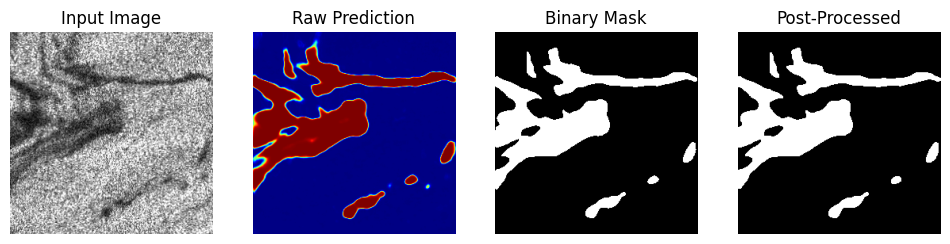

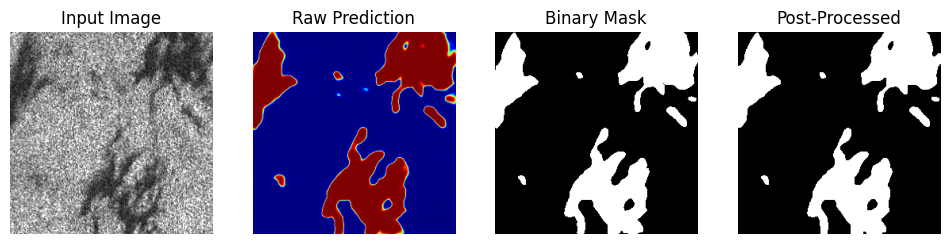

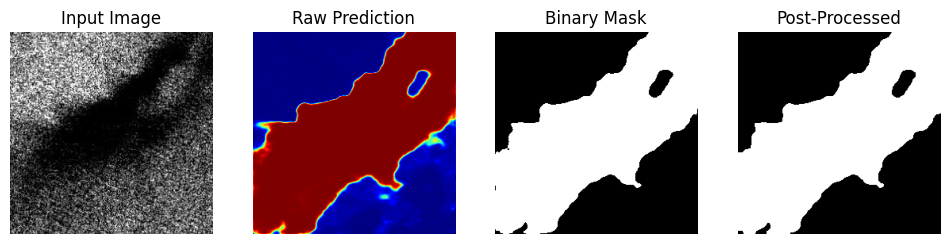

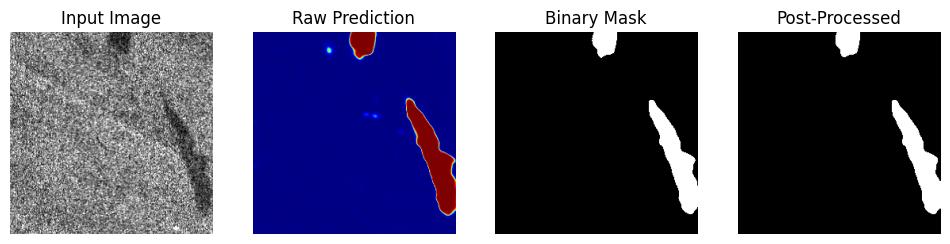

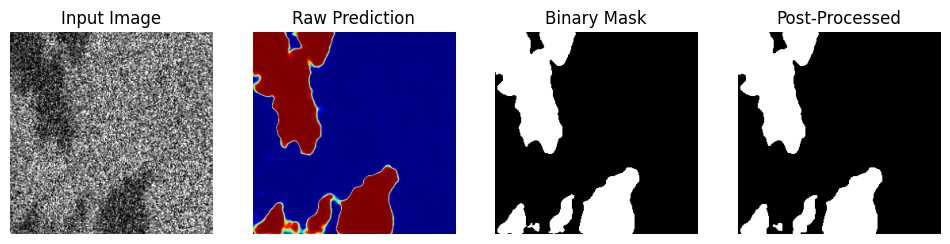

In [71]:
for i in range(5):  # test 5 images
    visualize_prediction(test_images[i])
